In [2]:
import random
import numpy as np
import pandas as pd
from copy import deepcopy
from rdkit import Chem, Geometry
from rdkit.Chem import AllChem, Draw, PandasTools, rdFMCS

In [3]:
sdf_supplier = Chem.ForwardSDMolSupplier('molecule_set_largest_cluster.sdf')
mols = list(sdf_supplier)
len(mols)

145

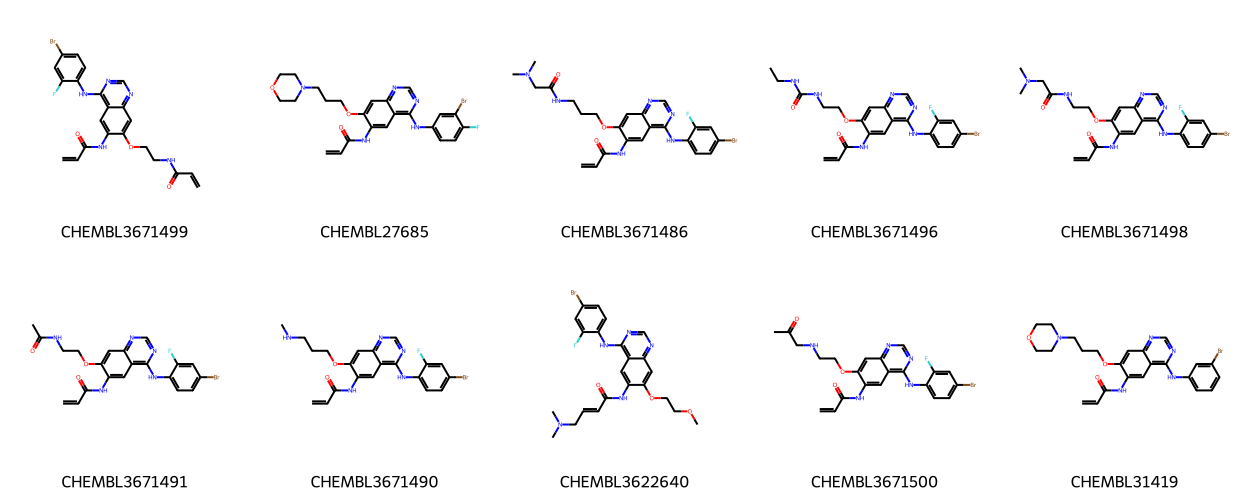

In [6]:
number = 10
Draw.MolsToGridImage(
    mols[:number],
    legends=[mol.GetProp('_Name') for mol in mols],
    molsPerRow=5,
    subImgSize=(250, 250)
)

In [30]:
mcs_1 = rdFMCS.FindMCS(mols)
print(f'MCS_1 has {mcs_1.numAtoms} atoms and {mcs_1.numBonds} bonds')
print(f'MCS_1 smarts string: {mcs_1.smartsString}')

MCS_1 has 24 atoms and 26 bonds
MCS_1 smarts string: [#6]-[#6](=[#8])-[#7]-[#6]1:[#6]:[#6]2:[#6](-[#7]-[#6]3:[#6]:[#6]:[#6]:[#6]:[#6]:3):[#7]:[#6]:[#7]:[#6]:2:[#6]:[#6]:1-[#8]-[#6]-[#6]


In [43]:
def highlight_molecules(molecules, mcs, number, same_orientation=True, **kwargs):
    molecules = deepcopy(molecules)
    pattern = Chem.MolFromSmarts(mcs.smartsString)
    matches = [molec.GetSubstructMatch(pattern) for molec in molecules[:number]]
    names = [molec.GetProp('_Name') for molec in molecules[:number]]

    if same_orientation:
        mol, match = molecules[0], matches[0]
        AllChem.Compute2DCoords(mol)
        coords = [mol.GetConformer().GetAtomPosition(x) for x in match]
        coords2D = [Geometry.Point2D(pt.x, pt.y) for pt in coords]
        for mol, match in zip(molecules[1:number], matches[1:number]):
            if not match:
                continue
            coord_dict = {match[i]: coord for i, coord in enumerate(coords2D)}
            AllChem.Compute2DCoords(mol, coordMap=coord_dict)

    return Draw.MolsToGridImage(
        molecules[:number],
        legends=names,
        highlightAtomLists=matches,
        molsPerRow=5,
        subImgSize=(200, 200),
        **kwargs
    )

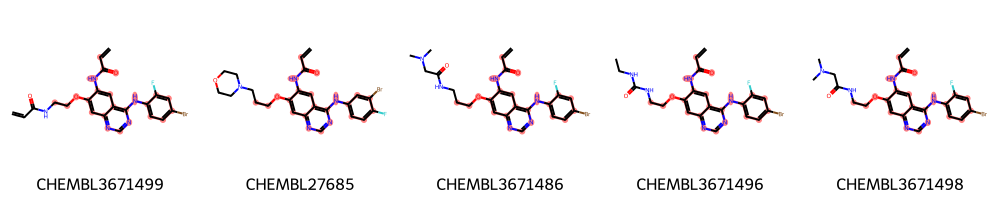

In [44]:
highlight_molecules(mols, mcs_1, 5)

In [45]:
mcs_2 = rdFMCS.FindMCS(mols, threshold=0.8)
print(f'MCS_2 has {mcs_2.numAtoms} atoms and {mcs_2.numBonds} bonds')
print(f'MCS_2 smarts string: {mcs_2.smartsString}')

MCS_2 has 28 atoms and 30 bonds
MCS_2 smarts string: [#6]=[#6]-[#6](=[#8])-[#7]-[#6]1:[#6]:[#6]2:[#6](-[#7]-[#6]3:[#6]:[#6]:[#6]:[#6]:[#6]:3-[#9]):[#7]:[#6]:[#7]:[#6]:2:[#6]:[#6]:1-[#8]-[#6]-[#6]-[#7]-[#6]


In [51]:
mcs_list = [mcs_1, mcs_2]
mcs_names = ['MCS1', 'MCS2: 80% threshold']

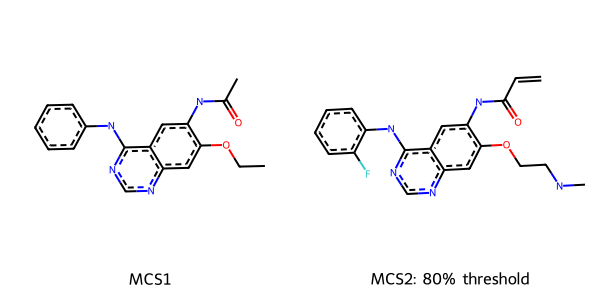

In [52]:
Draw.MolsToGridImage(
    [Chem.MolFromSmarts(mc.smartsString) for mc in mcs_list],
    legends=mcs_names,
    molsPerRow=2,
    subImgSize=(300, 300)
)

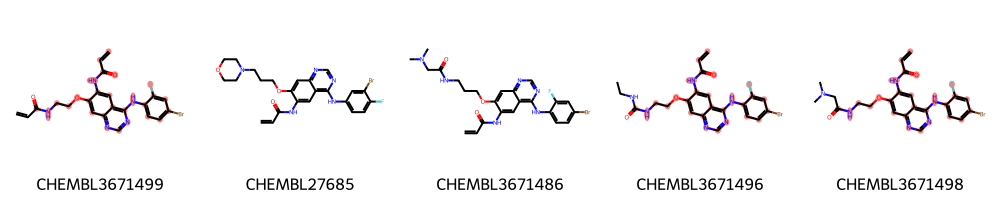

In [53]:
highlight_molecules(mols, mcs_2, 5)

In [55]:
mcs_3 = rdFMCS.FindMCS(mols, threshold=0.8, ringMatchesRingOnly=True)
print(f'MCS_3 has {mcs_3.numAtoms} atoms and {mcs_3.numBonds} bonds')
print(f'MCS_3 smarts string: {mcs_3.smartsString}')

MCS_3 has 28 atoms and 30 bonds
MCS_3 smarts string: [#6&!R]=&!@[#6&!R]-&!@[#6&!R](=&!@[#8&!R])-&!@[#7&!R]-&!@[#6]1:&@[#6]:&@[#6]2:&@[#6](-&!@[#7&!R]-&!@[#6]3:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@3-&!@[#9&!R]):&@[#7]:&@[#6]:&@[#7]:&@[#6]:&@2:&@[#6]:&@[#6]:&@1-&!@[#8&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#7&!R]-&!@[#6&!R]


In [56]:
mcs_list.append(mcs_3)
mcs_names.append('MCS3: 80% threshold + ringmatch')

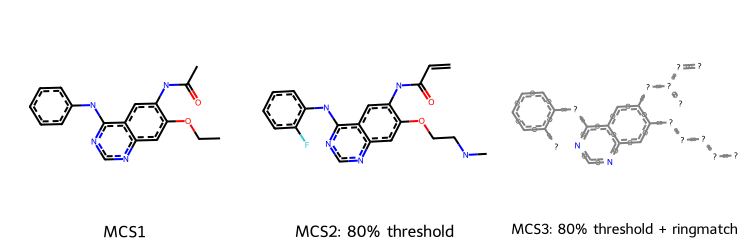

In [57]:
Draw.MolsToGridImage(
    [Chem.MolFromSmarts(mc.smartsString) for mc in mcs_list],
    legends=mcs_names,
    molsPerRow=3,
    subImgSize=(250, 250)
)

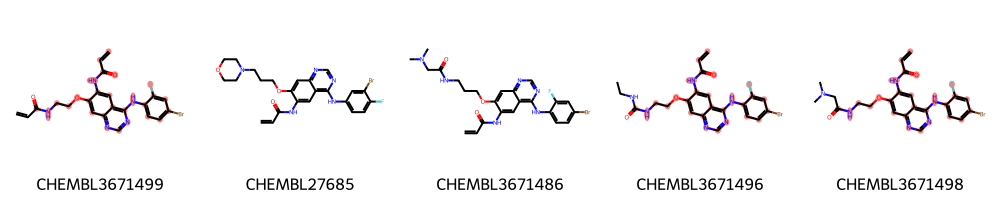

In [58]:
highlight_molecules(mols, mcs_3, 5)

In [59]:
data_df = pd.read_csv('EGFR_compounds.csv', index_col=0)
data_df.shape

(5568, 5)

In [60]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5568 entries, 0 to 5567
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  5568 non-null   object 
 1   IC50                5568 non-null   float64
 2   units               5568 non-null   object 
 3   smiles              5568 non-null   object 
 4   pIC50               5568 non-null   float64
dtypes: float64(2), object(3)
memory usage: 261.0+ KB


In [61]:
data_df = data_df[data_df['pIC50'] > 9]
data_df.shape

(186, 5)

In [62]:
mols_list = []
for _, row in data_df.iterrows():
    mol = Chem.MolFromSmiles(row['smiles'])
    mol.SetProp('_Name', row['molecule_chembl_id'])
    mols_list.append(mol)

In [63]:
random.seed(22)
mols_list = random.sample(mols_list, 50)
len(mols_list)

50

In [67]:
emcs_list = []
enames = []

In [65]:
emcs_1 = rdFMCS.FindMCS(mols_list)
print(f'EMCS_1 has {emcs_1.numAtoms} atoms and {emcs_1.numBonds} bonds')
print(f'EMCS_1 smarts string: {emcs_1.smartsString}')

EMCS_1 has 12 atoms and 12 bonds
EMCS_1 smarts string: [#6](:,-[#6]-,:[#7]-,:[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1):,-[#6]:,-[#7]:,-[#6]


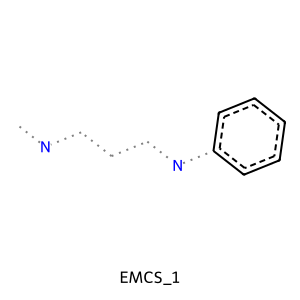

In [66]:
Draw.MolToImage(
    Chem.MolFromSmarts(emcs_1.smartsString),
    legend='EMCS_1'
)

In [68]:
emcs_list.append(emcs_1)
enames.append('EMCS_1')

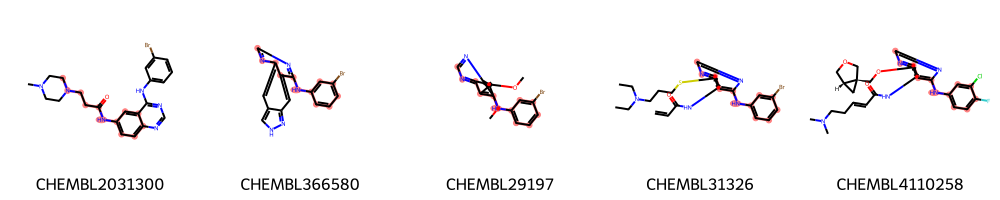

In [69]:
highlight_molecules(mols_list, emcs_1, 5)

In [70]:
emcs_2 = rdFMCS.FindMCS(mols_list, threshold=0.7)
print(f'EMCS_2 has {emcs_2.numAtoms} atoms and {emcs_2.numBonds} bonds')
print(f'EMCS_2 smarts string: {emcs_2.smartsString}')

EMCS_2 has 16 atoms and 17 bonds
EMCS_2 smarts string: [#6]:[#6]:[#6]1:[#6](-[#7]-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2):[#7]:[#6]:[#7]:[#6]:1:[#6]


In [71]:
emcs_list.append(emcs_2)
enames.append('EMCS_2: 70% threshold')

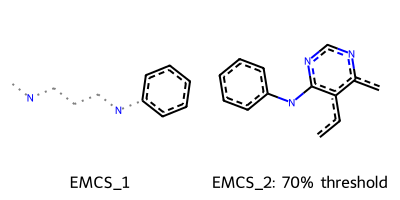

In [72]:
Draw.MolsToGridImage(
    [Chem.MolFromSmarts(mc.smartsString) for mc in emcs_list],
    legends=enames,
    molsPerRow=2,
    subImgSize=(200, 200)
)

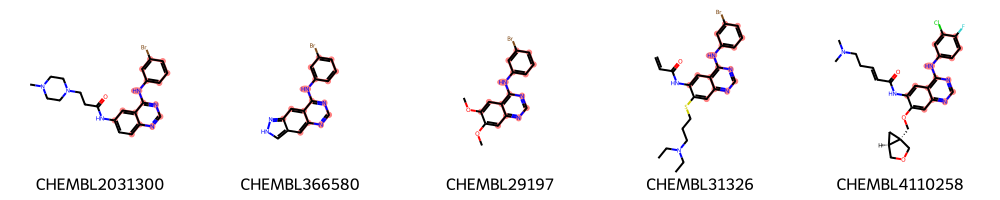

In [73]:
highlight_molecules(mols_list, emcs_2, 5)

In [74]:
emcs_3  = rdFMCS.FindMCS(mols_list, threshold=0.7, ringMatchesRingOnly=True)
print(f'EMCS_3 has {emcs_3.numAtoms} atoms and {emcs_3.numBonds} bonds')
print(f'EMCS_3 smarts string: {emcs_3.smartsString}')

EMCS_3 has 16 atoms and 17 bonds
EMCS_3 smarts string: [#6&R]:&@[#6&R]:&@[#6]1:&@[#6](-&!@[#7&!R]-&!@[#6]2:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2):&@[#7]:&@[#6]:&@[#7]:&@[#6]:&@1:&@[#6&R]


In [75]:
emcs_list.append(emcs_3)
enames.append('EMCS_3: 70% threshold + ringmatch')

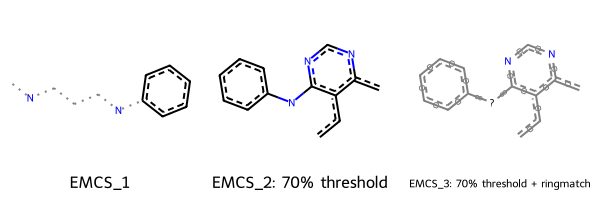

In [78]:
Draw.MolsToGridImage(
    [Chem.MolFromSmarts(mc.smartsString) for mc in emcs_list],
    legends=enames,
    molsPerRow=3
)

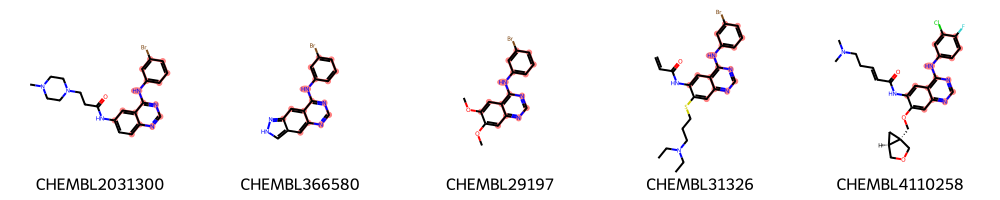

In [79]:
highlight_molecules(mols_list, emcs_3, 5)